## Phase 4 Project

##### Student Name:  Terry Thompson
##### Flex Student
##### Teacher: Morgan Jones

## Business Understanding:  
##### Bluestone Investment Group is looking to expand its interests in the state of Utah.  Bluestone has tasked us with finding the top areas in the state with the best ROI.  Bluestone would like to see what the ROI in these areas would be for three and five years.  We will predict the top 5 zipcodes that Bluestone should invest in using time series modelling.

In [2]:
# Import all tools needed.
import pandas as pd
from pandas.plotting import autocorrelation_plot,lag_plot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

## Data Understanding

##### Here we will look at the data and see what we have.

In [3]:
# Bring data in, assess the information.
df= pd.read_csv('zillow_data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14723 entries, 0 to 14722
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(49), object(4)
memory usage: 30.6+ MB


,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [4]:
# Check for null values.  The column "Metro" has 1043 null values.
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
              ... 
2017-12          0
2018-01          0
2018-02          0
2018-03          0
2018-04          0
Length: 272, dtype: int64

In [5]:
# RegionName is zipcodes.  Some of the zipcodes have only 4 numbers.  We will correct this.
df.RegionName.value_counts()

60657    1
7764     1
1226     1
13624    1
45335    1
        ..
22556    1
33761    1
38242    1
33602    1
89155    1
Name: RegionName, Length: 14723, dtype: int64

In [6]:
df.RegionName = df.RegionName.astype('string')

In [7]:
# https://www.skytowner.com/explore/adding_leading_zeros_to_strings_of_a_column_in_pandas
df.rename(columns={'RegionName': 'Zipcode'}, inplace=True)
df['Zipcode'] = df['Zipcode'].str.zfill(5)
df['Zipcode'].tail(5)

14718    01338
14719    03293
14720    40404
14721    81225
14722    89155
Name: Zipcode, dtype: string

In [1]:
# Verify that the zip codes are real.  The 01001 zip code is for Agawam, MA.
df[['Zipcode','City', 'State']].sort_values(by=['Zipcode'])

NameError: name 'df' is not defined

In [9]:
df.head()

,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


## Data Preparation

##### Since Bluestone is interested in Utah, we will prepare the data accordingly.  The approach will be by county, then zipcode.

In [10]:
utah =  df[df['State']=='UT']
utah.info()
utah.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 121 entries, 525 to 14714
Columns: 272 entries, RegionID to 2018-04
dtypes: float64(219), int64(48), object(4), string(1)
memory usage: 258.1+ KB


,RegionID,Zipcode,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
525,94562,84404,Ogden,UT,Ogden,Weber,526,107200.0,108200.0,109100.0,...,202900,204000,205300,206500,207800,209200,210700,213400,217000,219600
637,94384,84015,Clearfield,UT,Ogden,Davis,638,120600.0,121200.0,121800.0,...,217500,220400,222300,223900,226200,229000,230800,234900,239600,241500
1088,94410,84043,Lehi,UT,Provo,Utah,1089,174300.0,174800.0,175000.0,...,336200,338900,339700,340000,341900,344700,347300,349200,351900,354900
1231,94408,84041,Layton,UT,Ogden,Davis,1232,130500.0,131000.0,131500.0,...,235100,236000,236800,238600,241000,243900,246200,250700,255200,256300
1419,94479,84119,West Valley City,UT,Salt Lake City,Salt Lake,1420,118300.0,118200.0,118300.0,...,236800,242100,246900,249800,251900,254100,256000,258600,261400,262700


In [11]:
## Create a 5 year ROI.
utah['ROI_5yr'] = round((utah['2018-04'] - utah['2013-01'])/ utah['2013-01'],4)
## Create a 3 year ROI.
utah['ROI_3yr'] = round((utah['2018-04'] - utah['2015-01'])/ utah['2015-01'],4)

In [12]:
utah['ROI_3yr'].isna().sum()

0

In [13]:
utah['ROI_5yr'].isna().sum()

0

In [14]:
utah.sort_values('ROI_5yr', ascending = False).head()[['Zipcode','CountyName','State','ROI_5yr']]

,Zipcode,CountyName,State,ROI_5yr
6557,84111,Salt Lake,UT,0.8112
9058,84101,Salt Lake,UT,0.7784
6211,84104,Salt Lake,UT,0.7536
3637,84116,Salt Lake,UT,0.7383
5280,84044,Salt Lake,UT,0.7239


In [15]:
utah.sort_values('ROI_3yr', ascending = False).head()[['Zipcode','CountyName','State','ROI_3yr']]

,Zipcode,CountyName,State,ROI_3yr
9058,84101,Salt Lake,UT,0.6230
6557,84111,Salt Lake,UT,0.6040
3637,84116,Salt Lake,UT,0.5812
6211,84104,Salt Lake,UT,0.5719
14411,84757,Washington,UT,0.5656


In [16]:
# The time series does not require these columns.
utah.drop(['RegionID', 'City', 'Metro'], axis=1, inplace=True)
utah.head()

,Zipcode,State,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04,ROI_5yr,ROI_3yr
525,84404,UT,Weber,526,107200.0,108200.0,109100.0,109900.0,110700.0,111400.0,...,205300,206500,207800,209200,210700,213400,217000,219600,0.5093,0.4159
637,84015,UT,Davis,638,120600.0,121200.0,121800.0,122500.0,123100.0,123600.0,...,222300,223900,226200,229000,230800,234900,239600,241500,0.4672,0.3667
1088,84043,UT,Utah,1089,174300.0,174800.0,175000.0,175000.0,174600.0,173900.0,...,339700,340000,341900,344700,347300,349200,351900,354900,0.4575,0.2789
1231,84041,UT,Davis,1232,130500.0,131000.0,131500.0,132000.0,132500.0,133000.0,...,236800,238600,241000,243900,246200,250700,255200,256300,0.4407,0.3321
1419,84119,UT,Salt Lake,1420,118300.0,118200.0,118300.0,118400.0,118600.0,118800.0,...,246900,249800,251900,254100,256000,258600,261400,262700,0.6553,0.4960


In [17]:
# Function taken from starter notebook.
def melt_data(df):
    melted = pd.melt(df, id_vars=['Zipcode', 'State', 'CountyName', 'SizeRank', 'ROI_5yr', 'ROI_3yr'], 
                     var_name='Date')
    melted['Date'] = pd.to_datetime(melted['Date'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [18]:
melted_target = melt_data(utah)

In [19]:
# Check for null values.
melted_target.isna()

,Zipcode,State,CountyName,SizeRank,ROI_5yr,ROI_3yr,Date,value
0,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...
32060,False,False,False,False,False,False,False,False
32061,False,False,False,False,False,False,False,False
32062,False,False,False,False,False,False,False,False
32063,False,False,False,False,False,False,False,False


In [20]:
# Make sure the data type of the 'Date' column is datetime
melted_target['Date'] = pd.to_datetime(melted_target['Date'], format='%m/%y')

# Set the 'Date' column as index
melted_target.set_index('Date', inplace=True)

In [21]:
melted_target.index

DatetimeIndex(['1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01', '1996-04-01', '1996-04-01',
               '1996-04-01', '1996-04-01',
               ...
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01', '2018-04-01', '2018-04-01',
               '2018-04-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=31230, freq=None)

In [22]:
melted_target = melted_target['2008-04-01':'2018-04-01']

In [23]:
melted_target.resample('MS').mean().index

DatetimeIndex(['2008-04-01', '2008-05-01', '2008-06-01', '2008-07-01',
               '2008-08-01', '2008-09-01', '2008-10-01', '2008-11-01',
               '2008-12-01', '2009-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', name='Date', length=121, freq='MS')

In [24]:
melted_target.info()
melted_target.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14526 entries, 2008-04-01 to 2018-04-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Zipcode     14526 non-null  string 
 1   State       14526 non-null  object 
 2   CountyName  14526 non-null  object 
 3   SizeRank    14526 non-null  int64  
 4   ROI_5yr     14526 non-null  float64
 5   ROI_3yr     14526 non-null  float64
 6   value       14526 non-null  float64
dtypes: float64(3), int64(1), object(2), string(1)
memory usage: 907.9+ KB


,Zipcode,State,CountyName,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,,
2008-04-01,84404,UT,Weber,526,0.5093,0.4159,170000.0
2008-04-01,84015,UT,Davis,638,0.4672,0.3667,193200.0
2008-04-01,84043,UT,Utah,1089,0.4575,0.2789,289500.0
2008-04-01,84041,UT,Davis,1232,0.4407,0.3321,203600.0
2008-04-01,84119,UT,Salt Lake,1420,0.6553,0.4960,196200.0


## EDA

### Home Values by County

In [25]:
county = melted_target.groupby('CountyName')
county = county.value.mean()
county = county.sort_values(ascending=False).head(10)

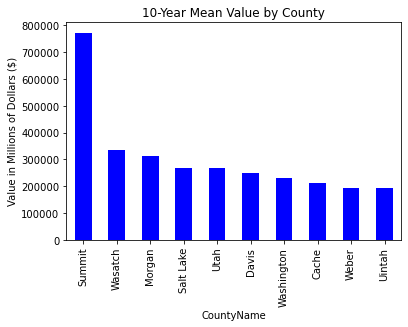

In [26]:
county.plot.bar(color='blue')
plt.title('10-Year Mean Value by County')
plt.ylabel('Value in Millions of Dollars ($)')
plt.show();

#### We will now look at the top five counties with the highest mean values.  These are:  Summit, Wasatch, Morgan, Salt Lake, and Utah counties.

In [27]:
summit = melted_target.loc[melted_target['CountyName']=='Summit']
summit.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,242.000000,242.000000,242.000000,2.420000e+02
mean,7039.500000,0.479700,0.274550,7.722293e+05
std,1666.947672,0.020242,0.018989,1.914860e+05
min,5376.000000,0.459500,0.255600,5.183000e+05
25%,5376.000000,0.459500,0.255600,5.946500e+05
50%,7039.500000,0.479700,0.274550,7.838500e+05
75%,8703.000000,0.499900,0.293500,8.923000e+05
max,8703.000000,0.499900,0.293500,1.222100e+06


In [28]:
wasatch = melted_target.loc[melted_target['CountyName']=='Wasatch']
wasatch.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,242.00000,242.000000,242.000000,242.000000
mean,8278.50000,0.459000,0.275000,335869.008264
std,2222.09586,0.002205,0.005712,54255.215921
min,6061.00000,0.456800,0.269300,253900.000000
25%,6061.00000,0.456800,0.269300,297425.000000
50%,8278.50000,0.459000,0.275000,328950.000000
75%,10496.00000,0.461200,0.280700,372500.000000
max,10496.00000,0.461200,0.280700,476100.000000


In [29]:
morgan = melted_target.loc[melted_target['CountyName']== 'Morgan']
morgan.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,121.0,121.0000,121.0000,121.000000
mean,9066.0,0.3322,0.3863,312657.024793
std,0.0,0.0000,0.0000,32396.709778
min,9066.0,0.3322,0.3863,266400.000000
25%,9066.0,0.3322,0.3863,292300.000000
50%,9066.0,0.3322,0.3863,304300.000000
75%,9066.0,0.3322,0.3863,334000.000000
max,9066.0,0.3322,0.3863,389400.000000


In [30]:
salt_lake = melted_target.loc[melted_target['CountyName']=='Salt Lake']
salt_lake.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,4235.000000,4235.000000,4235.000000,4235.000000
mean,3967.800000,0.582309,0.402129,269970.861865
std,1655.524263,0.121911,0.110430,91605.938430
min,1420.000000,0.327200,0.220700,109600.000000
25%,2239.000000,0.499100,0.305800,195400.000000
50%,3858.000000,0.574300,0.375400,255600.000000
75%,4934.000000,0.691100,0.496000,333200.000000
max,9059.000000,0.811200,0.623000,549300.000000


In [31]:
utah_cnty = melted_target.loc[melted_target['CountyName']=='Utah']
utah_cnty.describe()

,SizeRank,ROI_5yr,ROI_3yr,value
count,2299.000000,2299.000000,2299.000000,2299.000000
mean,5494.631579,0.480832,0.292432,269797.651153
std,2796.839284,0.059742,0.051711,87085.276393
min,1089.000000,0.375400,0.210200,155800.000000
25%,3227.000000,0.435700,0.259500,210550.000000
50%,4443.000000,0.481000,0.279800,250600.000000
75%,8963.000000,0.526500,0.341900,302550.000000
max,10033.000000,0.607800,0.380800,700200.000000


In [32]:
melted_target['value'].describe()

count    1.452600e+04
mean     2.459903e+05
std      1.067229e+05
min      1.096000e+05
25%      1.809000e+05
50%      2.214000e+05
75%      2.765000e+05
max      1.222100e+06
Name: value, dtype: float64

### Value

In [33]:
print('10 year average target home value' ,round(melted_target['value'].mean(), 2))

10 year average target home value 245990.29


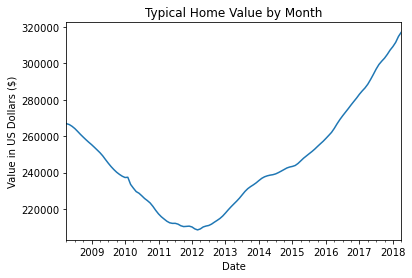

In [34]:
# Value by month.
monthly_data = melted_target.resample('MS').mean()['value']
monthly_data.plot()
plt.title('Typical Home Value by Month')
plt.ylabel('Value in US Dollars ($)')
plt.show();

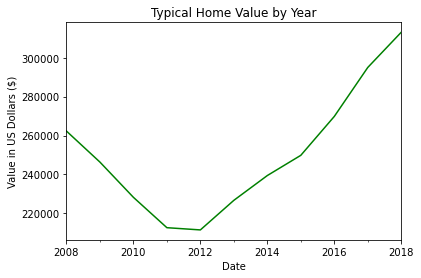

In [35]:
#Value by year end.
# https://stackoverflow.com/questions/17001389/pandas-resample-documentation.
yearly_data = melted_target['value'].resample(rule='A').mean()
yearly_data.plot.line(color='green')
plt.title('Typical Home Value by Year')
plt.ylabel('Value in US Dollars ($)')
plt.show();

## Mean value by zipcode

In [36]:
zips = melted_target.groupby('Zipcode')

In [37]:
mean_value = zips.value.mean()
mean_value = mean_value.sort_values(ascending=False).head(10)

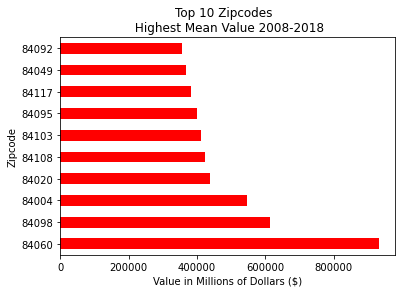

In [38]:
mean_value.plot.barh(color='red')
plt.title('Top 10 Zipcodes  \n Highest Mean Value 2008-2018')
plt.xlabel('Value in Millions of Dollars ($)')
plt.show();

In [39]:
melted_target['ROI_5yr'].describe()

count    14526.000000
mean         0.460834
std          0.139671
min          0.138200
25%          0.366900
50%          0.462500
75%          0.543900
max          0.811200
Name: ROI_5yr, dtype: float64

##### To narrow down the amount of zipcodes and find the best ones to invest in, I will take the top ten percent of zipcodes based on their 3 and 5 year ROIs.

In [40]:
ninety_perc_ROI_5yr = melted_target['ROI_5yr'].quantile(q=0.90)
top_ten_perc = melted_target.loc[melted_target['ROI_5yr']>=ninety_perc_ROI_5yr]

In [41]:
top_ten_perc.head(10)

,Zipcode,State,CountyName,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,,
2008-04-01,84119,UT,Salt Lake,1420,0.6553,0.4960,196200.0
2008-04-01,84120,UT,Salt Lake,2194,0.6762,0.4547,203000.0
2008-04-01,84106,UT,Salt Lake,2217,0.6911,0.4949,271100.0
2008-04-01,84403,UT,Weber,2705,0.6296,0.4443,176300.0
2008-04-01,84116,UT,Salt Lake,3638,0.7383,0.5812,181400.0
2008-04-01,84118,UT,Salt Lake,3653,0.7209,0.5133,197600.0
2008-04-01,84115,UT,Salt Lake,3858,0.7052,0.5521,189600.0
2008-04-01,84105,UT,Salt Lake,4656,0.7065,0.5072,305000.0
2008-04-01,84044,UT,Salt Lake,5281,0.7239,0.5612,182900.0


In [42]:
melted_target['ROI_3yr'].describe()

count    14526.000000
mean         0.309420
std          0.116767
min         -0.033800
25%          0.243600
50%          0.290200
75%          0.366700
max          0.623000
Name: ROI_3yr, dtype: float64

In [43]:
ninety_perc_ROI_3yr = melted_target['ROI_3yr'].quantile(q=0.90)
top_ten_perc_3yr = melted_target.loc[melted_target['ROI_3yr']>=ninety_perc_ROI_3yr]

In [44]:
top_3_utah = top_ten_perc_3yr.drop(columns=['CountyName', 'State', 'SizeRank'])
top_3_utah.head(10)

,Zipcode,ROI_5yr,ROI_3yr,value
Date,,,,
2008-04-01,84119,0.6553,0.4960,196200.0
2008-04-01,84106,0.6911,0.4949,271100.0
2008-04-01,84401,0.5439,0.4859,161100.0
2008-04-01,84116,0.7383,0.5812,181400.0
2008-04-01,84118,0.7209,0.5133,197600.0
2008-04-01,84115,0.7052,0.5521,189600.0
2008-04-01,84102,0.6192,0.4789,273400.0
2008-04-01,84105,0.7065,0.5072,305000.0
2008-04-01,84044,0.7239,0.5612,182900.0


In [45]:
top_3_utah.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1573 entries, 2008-04-01 to 2018-04-01
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Zipcode  1573 non-null   string 
 1   ROI_5yr  1573 non-null   float64
 2   ROI_3yr  1573 non-null   float64
 3   value    1573 non-null   float64
dtypes: float64(3), string(1)
memory usage: 61.4 KB


In [46]:
zipcode = top_3_utah['Zipcode'].unique().tolist()

In [47]:
TS = {}
for zipcode in zipcode:
    temp_df = top_3_utah.groupby('Zipcode').get_group(zipcode).sort_index()['value']
    TS[zipcode] = temp_df

In [48]:
len(TS.keys())

13

In [49]:
zip_df = pd.DataFrame(TS)
zip_df.head()

,84119,84106,84401,84116,84118,84115,84102,84105,84044,84104,84111,84101,84757
Date,,,,,,,,,,,,,
2008-04-01,196200.0,271100.0,161100.0,181400.0,197600.0,189600.0,273400.0,305000.0,182900.0,151600.0,196500.0,141400.0,384100.0
2008-05-01,196200.0,271200.0,162300.0,181100.0,197700.0,188500.0,273000.0,304600.0,183000.0,152800.0,195200.0,139900.0,377700.0
2008-06-01,196100.0,270600.0,163300.0,180600.0,197200.0,187700.0,272900.0,303600.0,182900.0,153400.0,194600.0,139400.0,372400.0
2008-07-01,195400.0,269200.0,163600.0,180200.0,195900.0,187100.0,272400.0,302400.0,182700.0,153200.0,194400.0,139900.0,368800.0
2008-08-01,194200.0,267300.0,163300.0,179300.0,194100.0,186400.0,270800.0,300900.0,182100.0,152200.0,194100.0,140800.0,365300.0


### Modeling

##### We will construct a model manually first.

In [50]:
zip_one = '84116'

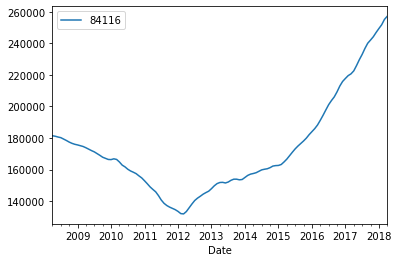

In [51]:
ts = zip_df[zip_one].copy()
ax = ts.plot()
ax.legend()
plt.show()

In [52]:
def plot_acf_pacf(ts, figsize=(10,8),lags=24):
    
    fig,ax = plt.subplots(nrows=3,
                          figsize=figsize)
    
    ## Plot ts
    ts.plot(ax=ax[0])
    
    ## Plot acf, pacf
    plot_acf(ts,ax=ax[1],lags=lags)
    plot_pacf(ts, ax=ax[2],lags=lags) 
    fig.tight_layout()
    
    fig.suptitle(f"Zipcode: {ts.name}",y=1.1,fontsize=20)
    
    return fig,ax

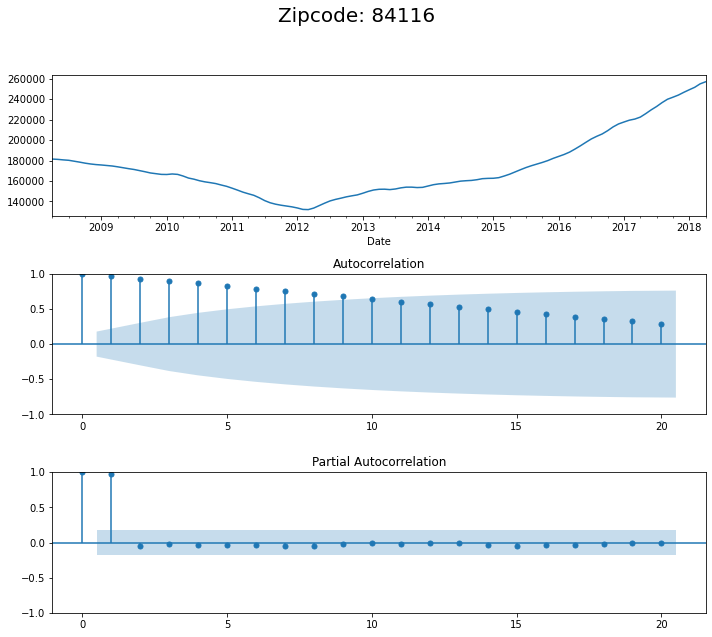

In [53]:
plot_acf_pacf(ts,lags=20);

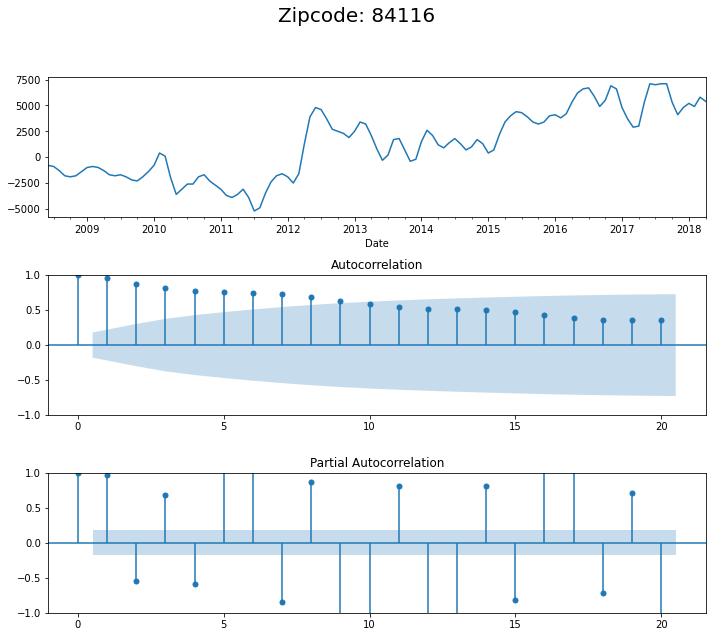

In [54]:
d = 2
plot_acf_pacf(ts.diff(d).dropna(),lags=20);

In [55]:
d = 2
p = 1
q = 1

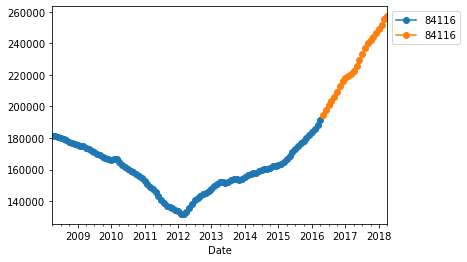

In [56]:
train_size = 0.8
split_idx = round(len(ts)* train_size)
split_idx

## Split
train = ts.iloc[:split_idx]
test = ts.iloc[split_idx:]

## Visualize split
fig,ax= plt.subplots()
kws = dict(ax=ax,marker='o')
train.plot(**kws)
test.plot(**kws)
ax.legend(bbox_to_anchor=[1,1])
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84116   No. Observations:                   97
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -724.666
Date:                Thu, 19 Jan 2023   AIC                           1455.331
Time:                        09:38:51   BIC                           1462.993
Sample:                    04-01-2008   HQIC                          1458.427
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7785      0.763     -1.020      0.308      -2.274       0.717
ma.L1          0.7905      0.746      1.060      0.289      -0.671       2.252
sigma2      2.209e+05    2.6e+04      8.498      0.000     1.7e+05    2.72e+05
===================================================================================
Ljung-Box (L1) (Q):                  11.36   Jarque-Bera (JB):                 5.35
Prob(Q):                              0.00   Prob(JB):                         0.07
Heteroskedasticity (H):               1.16   Skew:                             0.49
Prob(H) (two-sided):                  0.68   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

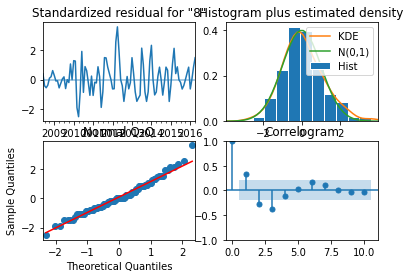

In [57]:
model = SARIMAX(train,order=(p,d,q)).fit()
display(model.summary())
model.plot_diagnostics();
plt.show()

In [58]:
forecast = model.get_forecast(steps=len(test))

In [59]:
def forecast_to_df(forecast,zipcode):
    test_pred = forecast.conf_int()
    test_pred[zipcode] = forecast.predicted_mean
    test_pred.columns = ['lower','upper','prediction']
    return test_pred


pred_df = forecast_to_df(forecast,zipcode)

In [60]:
def plot_train_test_pred(train,test,pred_df):
    fig,ax = plt.subplots()
    kws = dict(marker='o')
    
    ax.plot(train,label='Train',**kws)
    ax.plot(test,label='Test',**kws)
    ax.plot(pred_df['prediction'],label='prediction',ls='--',**kws)

    ax.fill_between(x=pred_df.index,y1=pred_df['lower'],y2=pred_df['upper'])
    ax.legend(bbox_to_anchor=[1,1])
    fig.tight_layout()
    return fig,ax

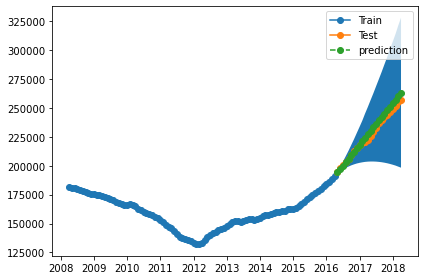

In [61]:
plot_train_test_pred(train,test,pred_df)
plt.show()

##### Here we will get the parameters from pmdarima.

In [62]:
# https://alkaline-ml.com/pmdarima/setup.html
from pmdarima.arima import auto_arima

In [63]:
auto_model = auto_arima(train, start_p=0, start_q=0,
                     test='adf',
                     max_p=5, max_q=5,
                     m=1,
                     d=0,
                     seasonal = True,
                     start_P=0,start_Q=0,
                     D=0,
                     trace=True,
                     error_action= 'ignore',
                     suppress_warnings=True,
                     stepwise=True,with_intercept=False)



print(auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2602.828, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2535.147, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1589.459, Time=0.30 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.36 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1522.816, Time=0.39 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2520.066, Time=0.08 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.33 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1509.866, Time=0.37 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2516.644, Time=0.06 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.31 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=1495.293, Time=0.35 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2516.045, Time=0.06 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=inf, Time=0.34 sec
 ARIMA(1,0,5)(0,0,0)[0]             : AIC=1494.275, Time=0

In [64]:
auto_model.order

(1, 0, 5)

In [65]:
auto_model.seasonal_order

(0, 0, 0, 0)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0015      0.012     86.545      0.000       0.979       1.024
ma.L1          1.5806      0.710      2.225      0.026       0.188       2.973
ma.L2          1.4907      1.436      1.038      0.299      -1.324       4.305
ma.L3          0.9905      1.798      0.551      0.582      -2.534       4.515
ma.L4          0.5823      1.423      0.409      0.682      -2.207       3.371
ma.L5          0.1608      0.786      0.205      0.838      -1.379       1.701
sigma2      1.246e+06   3.02e+05      4.124      0.000    6.54e+05    1.84e+06


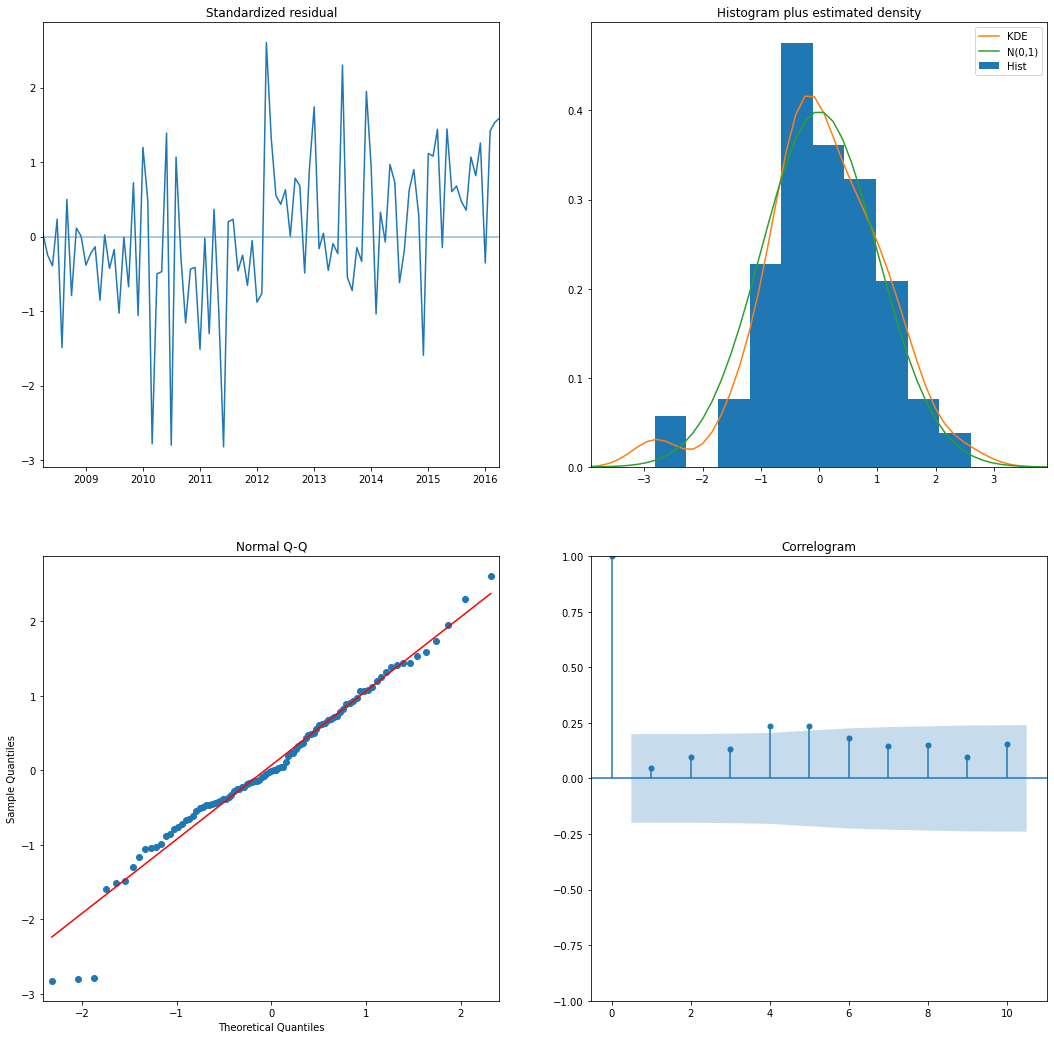

In [66]:
arima_model = sm.tsa.statespace.SARIMAX(train, 
                                        order=(1,0,5), 
                                        seasonal_order=(0, 0, 0, 0), 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)

# Fit the model and print results
output = arima_model.fit()

print(output.summary().tables[1])
auto_model.plot_diagnostics(figsize=(18,18))
plt.show()

In [67]:
train.index[-1]

Timestamp('2016-04-01 00:00:00')

In [68]:
pred = output.get_prediction(start=pd.to_datetime('2016-04'), end=pd.to_datetime('2018-04'), dynamic=False)
pred_conf = pred.conf_int()
pred_conf

,lower 84116,upper 84116
2016-04-01,188313.086014,192689.330952
2016-05-01,191886.401095,196262.646034
2016-06-01,190282.917354,202400.694806
2016-07-01,187010.043083,208576.977770
2016-08-01,183125.924858,214078.784461
2016-09-01,179189.743608,218842.667087
2016-10-01,175739.115124,222897.562640
2016-11-01,172799.932640,226441.929551
2016-12-01,170204.484297,229643.481074
2017-01-01,167860.394070,232594.594628


In [69]:
auto_model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 0, 5),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 0, 0, 0),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84116   No. Observations:                  121
Model:               SARIMAX(1, 0, 5)   Log Likelihood                -990.529
Date:                Thu, 19 Jan 2023   AIC                           1995.058
Time:                        09:38:59   BIC                           2014.629
Sample:                    04-01-2008   HQIC                          2003.007
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.004    253.632      0.000       0.992       1.007
ma.L1          1.5834      0.464      3.414      0.001       0.674       2.493
ma.L2          1.4687      0.892      1.646      0.100      -0.280       3.217
ma.L3          1.0753      1.070      1.005      0.315      -1.021       3.172
ma.L4          0.7562      0.870      0.870      0.385      -0.948       2.461
ma.L5          0.2363      0.543      0.435      0.663      -0.828       1.301
sigma2      1.529e+06   2.43e-07   6.28e+12      0.000    1.53e+06    1.53e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.46   Jarque-Bera (JB):                 0.93
Prob(Q):                              0.50   Prob(JB):                         0.63
Heteroskedasticity (H):               1.80   Skew:                            -0.04
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.94e+29. Standard errors may be unstable.
"""

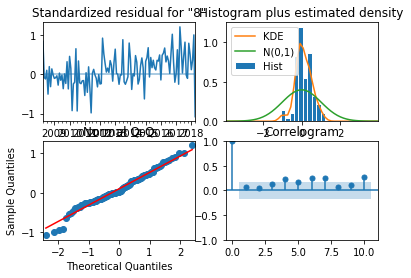

In [70]:
best_model = SARIMAX(ts,order=auto_model.order,
                     seasonal_order=auto_model.seasonal_order).fit()
display(best_model.summary())
best_model.plot_diagnostics();

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

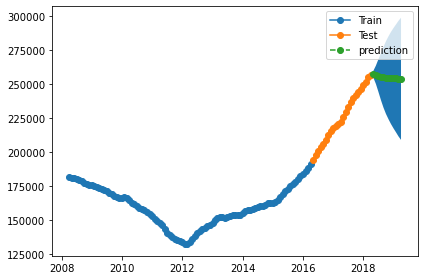

In [71]:
pred = best_model.get_forecast(steps=12)
pred_df = forecast_to_df(pred,zipcode)
display(plot_train_test_pred(train,test,pred_df));
plt.show()

84119


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84119   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -953.421
Date:                Thu, 19 Jan 2023   AIC                           1908.842
Time:                        09:39:01   BIC                           1911.622
Sample:                    04-01-2008   HQIC                          1909.971
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.327e+05   6.82e+04      7.816      0.000    3.99e+05    6.66e+05
===================================================================================
Ljung-Box (L1) (Q):                  24.97   Jarque-Bera (JB):                 0.20
Prob(Q):                              0.00   Prob(JB):                         0.90
Heteroskedasticity (H):               0.89   Skew:                            -0.10
Prob(H) (two-sided):                  0.72   Kurtosis:                         3.06
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

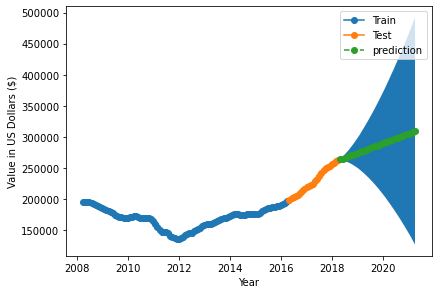

------------------------------------------------------------

84106


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84106   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -995.770
Date:                Thu, 19 Jan 2023   AIC                           1993.539
Time:                        09:39:02   BIC                           1996.319
Sample:                    04-01-2008   HQIC                          1994.668
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.085e+06      1e+05     10.809      0.000    8.89e+05    1.28e+06
===================================================================================
Ljung-Box (L1) (Q):                  10.82   Jarque-Bera (JB):                22.02
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                            -0.35
Prob(H) (two-sided):                  0.86   Kurtosis:                         4.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

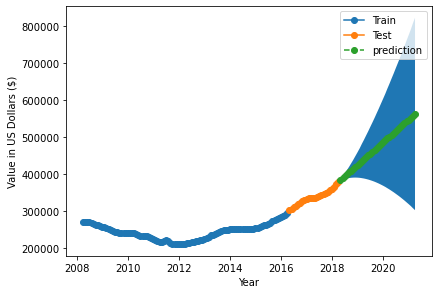

------------------------------------------------------------

84401


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84401   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -932.203
Date:                Thu, 19 Jan 2023   AIC                           1866.406
Time:                        09:39:02   BIC                           1869.185
Sample:                    04-01-2008   HQIC                          1867.535
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.729e+05   3.89e+04      9.597      0.000    2.97e+05    4.49e+05
===================================================================================
Ljung-Box (L1) (Q):                   9.62   Jarque-Bera (JB):                 7.22
Prob(Q):                              0.00   Prob(JB):                         0.03
Heteroskedasticity (H):               2.06   Skew:                             0.30
Prob(H) (two-sided):                  0.03   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

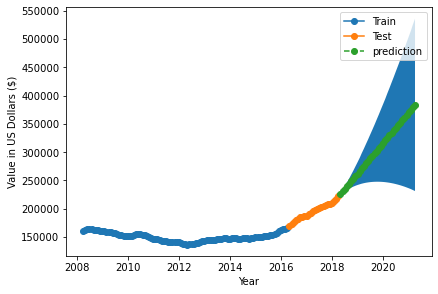

------------------------------------------------------------

84116


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84116   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -920.248
Date:                Thu, 19 Jan 2023   AIC                           1842.497
Time:                        09:39:03   BIC                           1845.276
Sample:                    04-01-2008   HQIC                          1843.625
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.05e+05   3.58e+04      8.529      0.000    2.35e+05    3.75e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.92   Jarque-Bera (JB):                 2.01
Prob(Q):                              0.01   Prob(JB):                         0.37
Heteroskedasticity (H):               1.92   Skew:                             0.24
Prob(H) (two-sided):                  0.04   Kurtosis:                         3.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

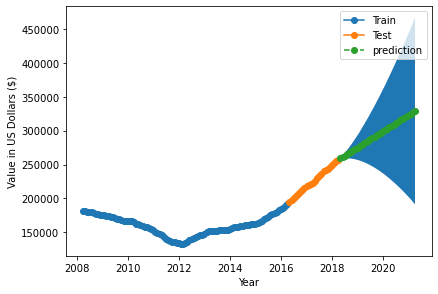

------------------------------------------------------------

84118


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84118   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -941.239
Date:                Thu, 19 Jan 2023   AIC                           1884.478
Time:                        09:39:04   BIC                           1887.257
Sample:                    04-01-2008   HQIC                          1885.606
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.341e+05   4.42e+04      9.820      0.000    3.47e+05    5.21e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.56   Jarque-Bera (JB):                 9.27
Prob(Q):                              0.00   Prob(JB):                         0.01
Heteroskedasticity (H):               1.11   Skew:                             0.32
Prob(H) (two-sided):                  0.73   Kurtosis:                         4.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

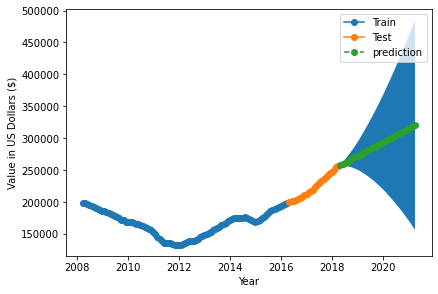

------------------------------------------------------------

84115


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84115   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -945.300
Date:                Thu, 19 Jan 2023   AIC                           1892.600
Time:                        09:39:04   BIC                           1895.380
Sample:                    04-01-2008   HQIC                          1893.729
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.647e+05   5.65e+04      8.223      0.000    3.54e+05    5.76e+05
===================================================================================
Ljung-Box (L1) (Q):                  20.47   Jarque-Bera (JB):                 0.38
Prob(Q):                              0.00   Prob(JB):                         0.83
Heteroskedasticity (H):               1.37   Skew:                            -0.02
Prob(H) (two-sided):                  0.32   Kurtosis:                         3.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

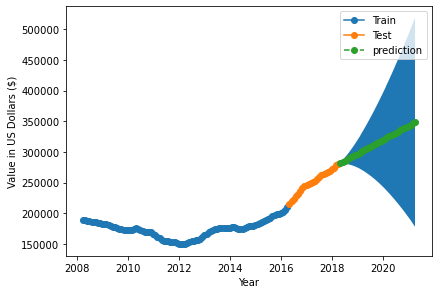

------------------------------------------------------------

84102


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84102   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1027.442
Date:                Thu, 19 Jan 2023   AIC                           2056.884
Time:                        09:39:05   BIC                           2059.663
Sample:                    04-01-2008   HQIC                          2058.013
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.832e+06   2.15e+05      8.515      0.000    1.41e+06    2.25e+06
===================================================================================
Ljung-Box (L1) (Q):                  13.48   Jarque-Bera (JB):                 1.45
Prob(Q):                              0.00   Prob(JB):                         0.48
Heteroskedasticity (H):               2.58   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

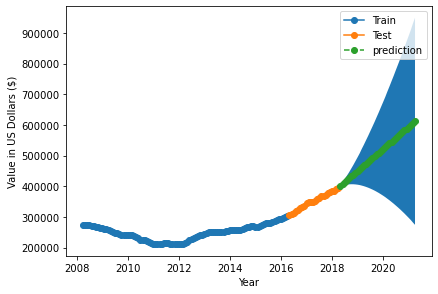

------------------------------------------------------------

84105


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84105   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1020.103
Date:                Thu, 19 Jan 2023   AIC                           2042.205
Time:                        09:39:06   BIC                           2044.984
Sample:                    04-01-2008   HQIC                          2043.334
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       1.62e+06   1.62e+05      9.974      0.000     1.3e+06    1.94e+06
===================================================================================
Ljung-Box (L1) (Q):                  14.73   Jarque-Bera (JB):                 8.28
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               1.18   Skew:                            -0.03
Prob(H) (two-sided):                  0.61   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

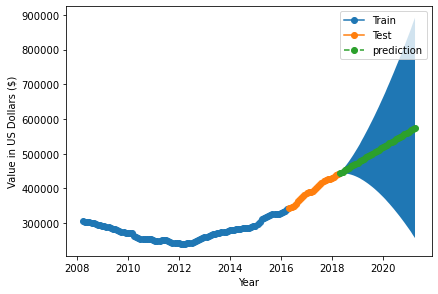

------------------------------------------------------------

84044


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84044   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -923.872
Date:                Thu, 19 Jan 2023   AIC                           1849.744
Time:                        09:39:06   BIC                           1852.523
Sample:                    04-01-2008   HQIC                          1850.872
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.242e+05   3.71e+04      8.745      0.000    2.52e+05    3.97e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.75   Jarque-Bera (JB):                 1.71
Prob(Q):                              0.00   Prob(JB):                         0.43
Heteroskedasticity (H):               1.36   Skew:                             0.09
Prob(H) (two-sided):                  0.34   Kurtosis:                         3.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

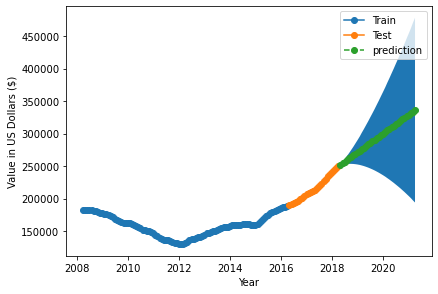

------------------------------------------------------------

84104


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84104   No. Observations:                  121
Model:               SARIMAX(1, 2, 0)   Log Likelihood                -940.399
Date:                Thu, 19 Jan 2023   AIC                           1884.798
Time:                        09:39:07   BIC                           1890.357
Sample:                    04-01-2008   HQIC                          1887.056
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0258      0.032      0.809      0.418      -0.037       0.088
sigma2      4.247e+05   5.69e+04      7.461      0.000    3.13e+05    5.36e+05
===================================================================================
Ljung-Box (L1) (Q):                   6.94   Jarque-Bera (JB):                 0.61
Prob(Q):                              0.01   Prob(JB):                         0.74
Heteroskedasticity (H):               2.95   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

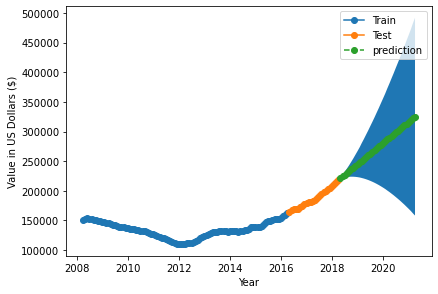

------------------------------------------------------------

84111


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84111   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood                -975.926
Date:                Thu, 19 Jan 2023   AIC                           1953.852
Time:                        09:39:08   BIC                           1956.632
Sample:                    04-01-2008   HQIC                          1954.981
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      7.776e+05   9.38e+04      8.294      0.000    5.94e+05    9.61e+05
===================================================================================
Ljung-Box (L1) (Q):                  14.11   Jarque-Bera (JB):                 1.06
Prob(Q):                              0.00   Prob(JB):                         0.59
Heteroskedasticity (H):               1.29   Skew:                             0.18
Prob(H) (two-sided):                  0.43   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

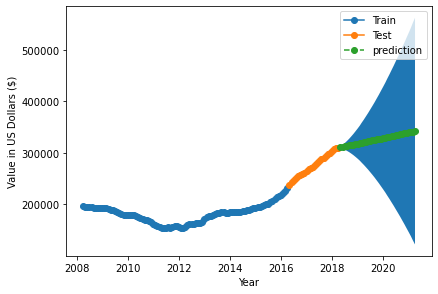

------------------------------------------------------------

84101


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84101   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1012.402
Date:                Thu, 19 Jan 2023   AIC                           2026.805
Time:                        09:39:09   BIC                           2029.584
Sample:                    04-01-2008   HQIC                          2027.933
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.435e+06   1.59e+05      9.025      0.000    1.12e+06    1.75e+06
===================================================================================
Ljung-Box (L1) (Q):                  17.89   Jarque-Bera (JB):                 3.66
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               2.09   Skew:                            -0.21
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

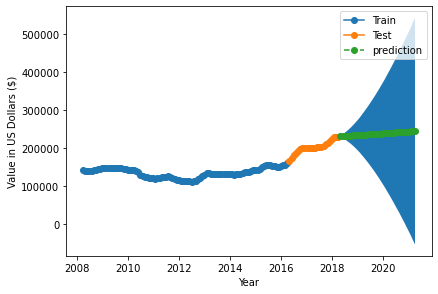

------------------------------------------------------------

84757


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  84757   No. Observations:                  121
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1036.059
Date:                Thu, 19 Jan 2023   AIC                           2074.117
Time:                        09:39:09   BIC                           2076.896
Sample:                    04-01-2008   HQIC                          2075.246
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.116e+06   2.16e+05      9.807      0.000    1.69e+06    2.54e+06
===================================================================================
Ljung-Box (L1) (Q):                   7.21   Jarque-Bera (JB):                10.08
Prob(Q):                              0.01   Prob(JB):                         0.01
Heteroskedasticity (H):               1.06   Skew:                            -0.31
Prob(H) (two-sided):                  0.85   Kurtosis:                         4.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

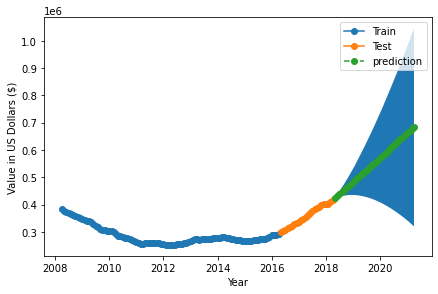

------------------------------------------------------------



In [72]:
RESULTS = {}

for zipcode in zip_df:
    print(zipcode)
    
    zipcode_d = {}
    
    ## Copy Time Series
    ts = zip_df[zipcode].copy()
    
    
    ## Train Test Split Index
    train_size = 0.8
    split_idx = round(len(ts)* train_size)

    ## Split
    train = ts.iloc[:split_idx]
    test = ts.iloc[split_idx:]
    
    
    ## Get best params using auto_arima
    gridsearch_model = auto_arima(ts,start_p=0,start_q=0)
    best_model = SARIMAX(ts,order=gridsearch_model.order,
                     seasonal_order=gridsearch_model.seasonal_order).fit()
    
    ## Get predictions
    pred  = best_model.get_forecast(steps=36)
    pred_df = forecast_to_df(pred,zipcode)

    ## Save info to dict
    zipcode_d['pred_df'] = pred_df
    zipcode_d['model'] = best_model
    zipcode_d['train'] = train
    zipcode_d['test'] = test
    
    ## Display Results
    display(best_model.summary())
    plot_train_test_pred(train,test,pred_df)
    plt.xlabel('Year')
    plt.ylabel('Value in US Dollars ($)')
    plt.show()
    
    
    ## Save district dict in RESULTS
    RESULTS[zipcode] = zipcode_d
    print('---'*20,end='\n\n')

In [73]:
top_ten_perc_3yr.head(5)

,Zipcode,State,CountyName,SizeRank,ROI_5yr,ROI_3yr,value
Date,,,,,,,
2008-04-01,84119,UT,Salt Lake,1420,0.6553,0.4960,196200.0
2008-04-01,84106,UT,Salt Lake,2217,0.6911,0.4949,271100.0
2008-04-01,84401,UT,Weber,2273,0.5439,0.4859,161100.0
2008-04-01,84116,UT,Salt Lake,3638,0.7383,0.5812,181400.0
2008-04-01,84118,UT,Salt Lake,3653,0.7209,0.5133,197600.0


## Conclusion

#### The top zip codes to invest in are:
##### 84116 with a 3 year ROI of 58.12% and a 5 year ROI of 73.83%
##### 84118 with a 3 year ROI of 51.33% and a 5 year ROI of 72.09%
#####  84119 with a 3 year ROI of 49.6% and a 5 year ROI of 65.53%
##### 84106 with a 3 year ROI of 49.49% and a 5 year ROI of 69.11%
##### 84401 with a 3 year ROI of 48.59% and a 5 year ROI of 54.39%

